In [1]:
pip install optuna 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np 
import pandas as pd
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from scipy import special
from tqdm import tqdm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score
# from sklearn_genetic import GAFeatureSelectionCV
# from sklearn_genetic.callbacks import ProgressBar
from lightgbm import LGBMClassifier, LGBMRegressor


warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)

In [4]:
data = pd.read_csv('widsdatathon2021/TrainingWiDS2021.csv')
data = data.drop(columns=['Unnamed: 0'])

In [5]:
data['ethnicity'].fillna('Other/Unknown', inplace=True)
data['hospital_admit_source'].fillna('Other', inplace=True)
data['icu_admit_source'].fillna('Other', inplace=True)
data['icu_admit_source'].replace(['Other Hospital', 'Other ICU'], 'Other', inplace=True)

gender_mapping = {'M': 0, 'F': 1}
data['gender'] = data['gender'].map(gender_mapping)

data['hospital_admit_source'] = data['hospital_admit_source'].replace({'Other ICU': 'ICU','ICU to SDU':'SDU',
                                                                             'Step-Down Unit (SDU)': 'SDU',
                                                                             'Other Hospital':'Other','Observation': 'Recovery Room',
                                                                             'Acute Care/Floor': 'Acute Care'})


data['age'] = np.where(data['age'].values == 0, np.nan, data['age'].values)
data = data.replace([np.inf, -np.inf], np.nan)
min_max_feats = [f[:-4] for f in data.columns if f[-4:] == '_min']
for col in min_max_feats:
    data.loc[data[f'{col}_min'] > data[f'{col}_max'], [f'{col}_min', f'{col}_max']] = \
        data.loc[data[f'{col}_min'] > data[f'{col}_max'], [f'{col}_max', f'{col}_min']].values

C:\Users\User\AppData\Local\Temp\ipykernel_15852\2556887359.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['ethnicity'].fillna('Other/Unknown', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_15852\2556887359.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [6]:
# missing_percentage = data.isnull().mean() * 100
# columns_to_drop = missing_percentage[missing_percentage > 80].index
# data_cleaned = data.drop(columns=columns_to_drop)
# data = data_cleaned

In [7]:
def feature_generation(df):

    agg = df['icu_id'].value_counts().to_dict()
    df['icu_id_counts'] = np.log1p(df['icu_id'].map(agg))
    agg = df['age'].value_counts().to_dict()
    df['age_counts'] = np.log1p(df['age'].map(agg))

    df['nan_counts'] = df.isnull().sum(axis=1)

    df['sq_age'] = df['age'].values ** 2
    df['sq_bmi'] = df['bmi'].values ** 2
    df['bmi_age'] = df['bmi'].values / df['age'].values
    df['weight_age'] = df['age'].values / df['weight'].values

    df['comorbidity_score'] = df['aids'].values * 23 + df['cirrhosis'].values * 4 + \
                                 df['hepatic_failure'].values * 16 + df['immunosuppression'].values * 10 + \
                              df['leukemia'].values * 10 + df['lymphoma'].values * 13 + df['solid_tumor_with_metastasis'].values * 11
    
    
    #source https://www.omnicalculator.com/health/risk-dm
    df['diabete_risk'] = 100 / (1 + np.exp(-1*(0.028*df['age'].values + 0.661*np.where(df['gender'].values=="M", 1, 0) +
                                               0.412 * np.where(df['ethnicity'].values=="Native American", 0, 1) +
                                               0.079 * df['glucose_apache'].values + 0.018 * df['d1_diasbp_max'].values +
                                               0.07 * df['bmi'].values + 0.481 * df['cirrhosis'].values - 13.415)))

    df['gcs_sum'] = df['gcs_eyes_apache'].values + df['gcs_motor_apache'].values + df['gcs_verbal_apache'].values
    df['apache_2_diagnosis_type'] = df.apache_2_diagnosis.round(-1).fillna(-100).astype('int32')
    df['apache_3j_diagnosis_type'] = df.apache_3j_diagnosis.round(-2).fillna(-100).astype('int32')
    df['bmi_type'] = df.bmi.fillna(0).apply(lambda x: 5 * (round(int(x) / 5)))
    df['height_type'] = df.height.fillna(0).apply(lambda x: 5 * (round(int(x) / 5)))
    df['weight_type'] = df.weight.fillna(0).apply(lambda x: 5 * (round(int(x) / 5)))
    df['age_type'] = df.age.fillna(0).apply(lambda x: 10 * (round(int(x) / 10)))
    df['gcs_sum_type'] = df.gcs_sum.fillna(0).apply(lambda x: 2.5 * (round(int(x) / 2.5))).divide(2.5)
    df['apache_3j_diagnosis_x'] = df['apache_3j_diagnosis'].astype('str').str.split('.', n=1, expand=True)[0]
    df['apache_2_diagnosis_x'] = df['apache_2_diagnosis'].astype('str').str.split('.', n=1, expand=True)[0]
    df['apache_3j_diagnosis_split1'] = np.where(df['apache_3j_diagnosis'].isna(), np.nan,
                                                   df['apache_3j_diagnosis'].astype('str').str.split('.', n=1,
                                                                                                        expand=True)[1])
    df['apache_2_diagnosis_split1'] = np.where(df['apache_2_diagnosis'].isna(), np.nan,
                                                  df['apache_2_diagnosis'].apply(lambda x: x % 10))

    IDENTIFYING_COLS = ['age_type', 'gcs_sum_type', 'ethnicity', 'gender', 'bmi_type']
    df['profile'] = df[IDENTIFYING_COLS].apply(lambda x: hash(tuple(x)), axis=1)

    df["diff_bmi"] = df['bmi'].copy()
    df['bmi'] = df['weight'].values / ((df['height'].values / 100) ** 2)
    df["diff_bmi"] = df["diff_bmi"].values - df['bmi'].values

    df['pre_icu_los_days'] = df['pre_icu_los_days'].apply(lambda x: special.expit(x))

    d_cols = [c for c in df.columns if (c.startswith("d1"))]
    h_cols = [c for c in df.columns if (c.startswith("h1"))]
    df["dailyLabs_row_nan_count"] = df[d_cols].isna().sum(axis=1)
    df["hourlyLabs_row_nan_count"] = df[h_cols].isna().sum(axis=1)
    df["diff_labTestsRun_daily_hourly"] = df["dailyLabs_row_nan_count"].values - df["hourlyLabs_row_nan_count"].values

    lab_col = [c for c in df.columns if ((c.startswith("h1")) | (c.startswith("d1")))]
    lab_col_names = list(set(list(map(lambda i: i[3: -4], lab_col))))

    first_h = []
    for v in tqdm(lab_col_names):
        colsx = [x for x in df.columns if v in x]
        df[v + "_nans"] = df.loc[:, colsx].isna().sum(axis=1)
        df[v + "_d1_h1_max_eq"] = (df[f"d1_{v}_max"] == df[f"h1_{v}_max"]).astype(np.int8)
        df[v + "_d1_h1_min_eq"] = (df[f"d1_{v}_min"] == df[f"h1_{v}_min"]).astype(np.int8)


        for freq in ['h1', 'd1']:
            df[v + f"_{freq}_value_range"] = df[f"{freq}_{v}_max"].subtract(df[f"{freq}_{v}_min"])
            df[v + f"_{freq}_zero_range"] = (df[v + f"_{freq}_value_range"] == 0).astype(np.int8)
            df[v + f"_{freq}_mean"] =np.nanmean(df[[f"{freq}_{v}_max", f"{freq}_{v}_min"]].values, axis=1)
            df[v + f"_{freq}_std"] = np.nanstd(df[[f"{freq}_{v}_max", f"{freq}_{v}_min"]].values, axis=1)

            for g in ['apache_3j_diagnosis', 'profile', 'icu_id']:
                for m in ['max', 'min']:
                    temp = df[[g, f"{freq}_{v}_{m}"]].groupby(g)
                    df[v + f"_{freq}_{m}_{g}_mean"] = temp.transform('mean')
                    df[v + f"_{freq}_{m}_{g}_diff"] = df[v + f"_{freq}_{m}_{g}_mean"].subtract(df[f"{freq}_{v}_{m}"])
                    df[v + f"_{freq}_{m}_{g}_std"] = temp.transform('std')
                    df[v + f"_{freq}_{m}_{g}_norm_std"] = df[v + f"_{freq}_{m}_{g}_std"].div(df[f"{freq}_{v}_{m}"])
                    df[v + f"_{freq}_{m}_{g}_rank"] =temp.transform('rank')
                    df[v + f"_{freq}_{m}_{g}_count"] = temp.transform('count')
                    df[v + f"_{freq}_{m}_{g}_norm_rank"] = df[v + f"_{freq}_{m}_{g}_rank"].div(df[v + f"_{freq}_{m}_{g}_count"])
                    df[v + f"_{freq}_{m}_{g}_skew"] = temp.transform('skew')

            if v + "_apache" in colsx:
                for m in ['max', 'min']:
                    df[v + f"_apache_{freq}_{m}_ratio"] = df[f"{freq}_{v}_{m}"].div(df[v + "_apache"])

            for m in ['max', 'min']:
                df[f"{freq}_{v}_{m}_bmi_ratio"] = df[f"{freq}_{v}_{m}"].div(df['bmi'])
                df[f"{freq}_{v}_{m}_weight_ratio"] = df[f"{freq}_{v}_{m}"].div(df['weight'])

        df[v + "_range_between_d_h"] = df[v + "_d1_mean"].values - df[v + "_h1_mean"].values
        df[v + "_d1_h1_mean"] = np.nanmean(df[[f"d1_{v}_max", f"d1_{v}_min", f"h1_{v}_max", f"h1_{v}_min"]].values, axis=1)
        df[v + "_d1_h1_std"] = np.nanstd(df[[f"d1_{v}_max", f"d1_{v}_min", f"h1_{v}_max", f"h1_{v}_min"]].values, axis=1)

        df[v + "_tot_change_value_range_normed"] = abs((df[v + "_d1_value_range"].div(df[v + "_h1_value_range"])))
        df[v + "_started_after_firstHour"] = ((df[f"h1_{v}_max"].isna()) & (df[f"h1_{v}_min"].isna())) & (~df[f"d1_{v}_max"].isna())
        first_h.append(v + "_started_after_firstHour")
        df[v + "_day_more_extreme"] = ((df[f"d1_{v}_max"] > df[f"h1_{v}_max"]) | (df[f"d1_{v}_min"] < df[f"h1_{v}_min"]))
        df[v + "_day_more_extreme"].fillna(False)

    df["total_Tests_started_After_firstHour"] = df[first_h].sum(axis=1)

    df['diasbp_indicator'] = (
            (df['d1_diasbp_invasive_max'] == df['d1_diasbp_max']) & (
            df['d1_diasbp_noninvasive_max'] == df['d1_diasbp_invasive_max']) |
            (df['d1_diasbp_invasive_min'] == df['d1_diasbp_min']) & (
                    df['d1_diasbp_noninvasive_min'] == df['d1_diasbp_invasive_min']) |
            (df['h1_diasbp_invasive_max'] == df['h1_diasbp_max']) & (
                    df['h1_diasbp_noninvasive_max'] == df['h1_diasbp_invasive_max']) |
            (df['h1_diasbp_invasive_min'] == df['h1_diasbp_min']) & (
                    df['h1_diasbp_noninvasive_min'] == df['h1_diasbp_invasive_min'])).astype(np.int8)

    df['mbp_indicator'] = (
            (df['d1_mbp_invasive_max'] == df['d1_mbp_max']) & (
            df['d1_mbp_noninvasive_max'] == df['d1_mbp_invasive_max']) |
            (df['d1_mbp_invasive_min'] == df['d1_mbp_min']) & (
                    df['d1_mbp_noninvasive_min'] == df['d1_mbp_invasive_min']) |
            (df['h1_mbp_invasive_max'] == df['h1_mbp_max']) & (
                    df['h1_mbp_noninvasive_max'] == df['h1_mbp_invasive_max']) |
            (df['h1_mbp_invasive_min'] == df['h1_mbp_min']) & (
                    df['h1_mbp_noninvasive_min'] == df['h1_mbp_invasive_min'])
    ).astype(np.int8)

    df['sysbp_indicator'] = (
            (df['d1_sysbp_invasive_max'] == df['d1_sysbp_max']) & (
            df['d1_sysbp_noninvasive_max'] == df['d1_sysbp_invasive_max']) |
            (df['d1_sysbp_invasive_min'] == df['d1_sysbp_min']) & (
                    df['d1_sysbp_noninvasive_min'] == df['d1_sysbp_invasive_min']) |
            (df['h1_sysbp_invasive_max'] == df['h1_sysbp_max']) & (
                    df['h1_sysbp_noninvasive_max'] == df['h1_sysbp_invasive_max']) |
            (df['h1_sysbp_invasive_min'] == df['h1_sysbp_min']) & (
                    df['h1_sysbp_noninvasive_min'] == df['h1_sysbp_invasive_min'])
    ).astype(np.int8)

    df['d1_mbp_invnoninv_max_diff'] = df['d1_mbp_invasive_max'].div(df['d1_mbp_noninvasive_max'])
    df['h1_mbp_invnoninv_max_diff'] = df['h1_mbp_invasive_max'].div(df['h1_mbp_noninvasive_max'])
    df['d1_mbp_invnoninv_min_diff'] = df['d1_mbp_invasive_min'].div(df['d1_mbp_noninvasive_min'])
    df['h1_mbp_invnoninv_min_diff'] = df['h1_mbp_invasive_min'].div(df['h1_mbp_noninvasive_min'])
    df['d1_diasbp_invnoninv_max_diff'] = df['d1_diasbp_invasive_max'].div(df['d1_diasbp_noninvasive_max'])
    df['h1_diasbp_invnoninv_max_diff'] = df['h1_diasbp_invasive_max'].div(df['h1_diasbp_noninvasive_max'])
    df['d1_diasbp_invnoninv_min_diff'] = df['d1_diasbp_invasive_min'].div(df['d1_diasbp_noninvasive_min'])
    df['h1_diasbp_invnoninv_min_diff'] = df['h1_diasbp_invasive_min'].div(df['h1_diasbp_noninvasive_min'])
    df['d1_sysbp_invnoninv_max_diff'] = df['d1_sysbp_invasive_max'].div(df['d1_sysbp_noninvasive_max'])
    df['h1_sysbp_invnoninv_max_diff'] = df['h1_sysbp_invasive_max'].div(df['h1_sysbp_noninvasive_max'])
    df['d1_sysbp_invnoninv_min_diff'] = df['d1_sysbp_invasive_min'].div(df['d1_sysbp_noninvasive_min'])
    df['h1_sysbp_invnoninv_min_diff'] = df['h1_sysbp_invasive_min'].div(df['h1_sysbp_noninvasive_min'])

    more_extreme_cols = [c for c in df.columns if (c.endswith("_day_more_extreme"))]
    df["total_day_more_extreme"] = df[more_extreme_cols].sum(axis=1)
    df["d1_resprate_div_mbp_min"] = df["d1_resprate_min"].div(df["d1_mbp_min"])
    df["d1_resprate_div_sysbp_min"] = df["d1_resprate_min"].div(df["d1_sysbp_min"])
    df["d1_lactate_min_div_diasbp_min"] = df["d1_lactate_min"].div(df["d1_diasbp_min"])
    df["d1_heartrate_min_div_d1_sysbp_min"] = df["d1_heartrate_min"].div(df["d1_sysbp_min"])
    df["total_chronic"] = df[["aids", "cirrhosis", 'hepatic_failure']].sum(axis=1)
    df["total_cancer_immuno"] = df[['immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].sum(axis=1)
    df["has_complicator"] = df[["aids", "cirrhosis", 'hepatic_failure','immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']].max(axis=1)

    df['apache_3j'] = np.where(df['apache_3j_diagnosis_type'] < 0, np.nan,
                               np.where(df['apache_3j_diagnosis_type'] < 200, 'Cardiovascular',
                                        np.where(df['apache_3j_diagnosis_type'] < 400, 'Respiratory',
                                                 np.where(df['apache_3j_diagnosis_type'] < 500, 'Neurological',
                                                          np.where(df['apache_3j_diagnosis_type'] < 600, 'Sepsis',
                                                                   np.where(df['apache_3j_diagnosis_type'] < 800,
                                                                            'Trauma',
                                                                            np.where(
                                                                                df['apache_3j_diagnosis_type'] < 900,
                                                                                'Haematological',
                                                                                np.where(df[
                                                                                             'apache_3j_diagnosis_type'] < 1000,
                                                                                         'Renal/Genitourinary',
                                                                                         np.where(df[
                                                                                                      'apache_3j_diagnosis_type'] < 1200,
                                                                                                  'Musculoskeletal/Skin disease',
                                                                                                  'Operative Sub-Diagnosis Codes')))))))))


    return df

In [8]:
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

for col in categorical_columns:
    unique_values = data[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values:")
    print(unique_values)
    print("\n")

print("Shape of Data:", data.shape)
print("Shape of Categorical:", categorical_columns.shape)
print("Shape of Numerical:", numerical_cols.shape)

Column 'ethnicity' has 6 unique values:
['Caucasian' 'Other/Unknown' 'Hispanic' 'African American' 'Asian'
 'Native American']


Column 'hospital_admit_source' has 11 unique values:
['Floor' 'Emergency Department' 'Operating Room' 'Other' 'Direct Admit'
 'ICU' 'SDU' 'Recovery Room' 'Chest Pain Center' 'Acute Care' 'PACU']


Column 'icu_admit_source' has 4 unique values:
['Floor' 'Accident & Emergency' 'Operating Room / Recovery' 'Other']


Column 'icu_stay_type' has 3 unique values:
['admit' 'readmit' 'transfer']


Column 'icu_type' has 8 unique values:
['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']


Shape of Data: (130157, 180)
Shape of Categorical: (5,)
Shape of Numerical: (175,)


In [9]:
# one_hot_encoded_data = pd.get_dummies(data[categorical_columns], drop_first=False)
# data = pd.concat([data, one_hot_encoded_data], axis=1)
# data = data.drop(columns=categorical_columns)

C:\Users\User\AppData\Local\Temp\ipykernel_15852\1653833469.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='diabetes_mellitus', data=data, palette='Set2')


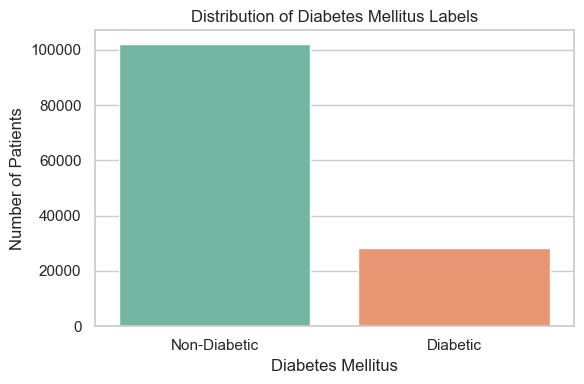

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for consistency
sns.set(style="whitegrid")

# Plotting class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='diabetes_mellitus', data=data, palette='Set2')
plt.title("Distribution of Diabetes Mellitus Labels")
plt.xlabel("Diabetes Mellitus")
plt.ylabel("Number of Patients")
plt.xticks([0, 1], ["Non-Diabetic", "Diabetic"])
plt.tight_layout()
# plt.savefig("figures/class_distribution.png", dpi=300)  # Optional: Save the figure
plt.show()


In [11]:
target_column_name = 'diabetes_mellitus'  
X = data.drop(columns=[target_column_name])
y = data[target_column_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (91109, 179)
Testing set shape: (39048, 179)


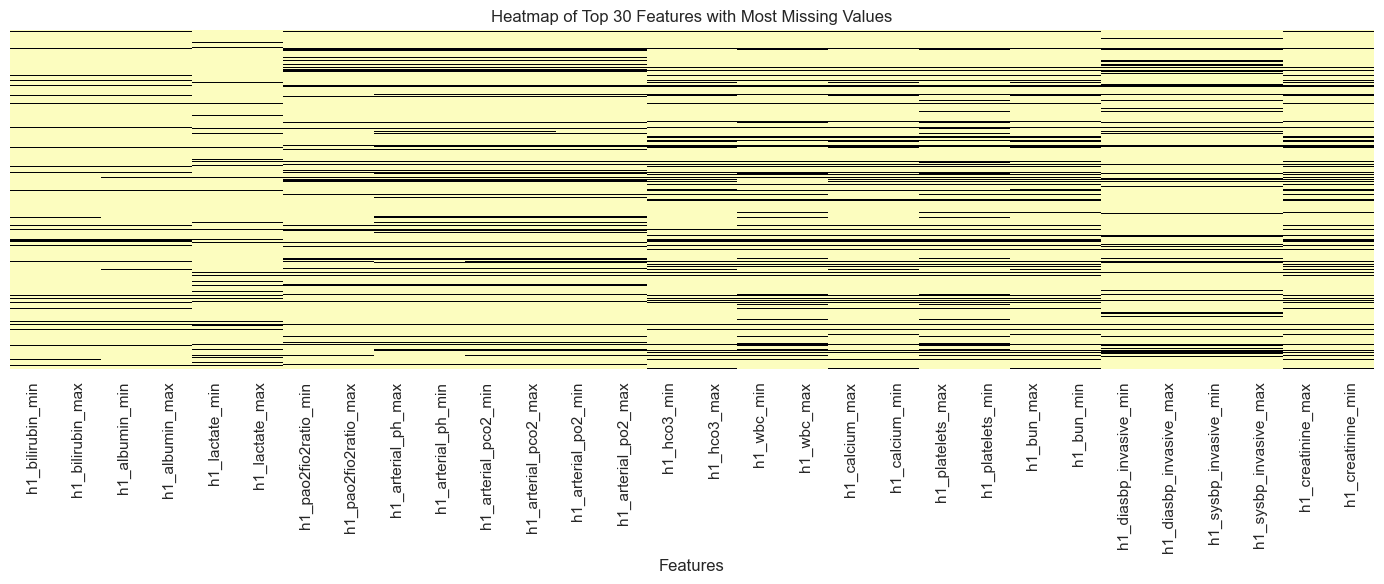

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate missing value percentage per column
missing_percent = data.isnull().mean().sort_values(ascending=False)

# Select top 30 features with most missing values
top_missing = missing_percent[missing_percent > 0].head(30).index

# Plot heatmap for only top missing columns
plt.figure(figsize=(14, 6))
sns.heatmap(data[top_missing].isnull(), cbar=False, yticklabels=False, cmap='magma')
plt.title("Heatmap of Top 30 Features with Most Missing Values")
plt.xlabel("Features")
plt.tight_layout()
# plt.savefig("figures/missing_value_heatmap_top30.png", dpi=300)
plt.show()


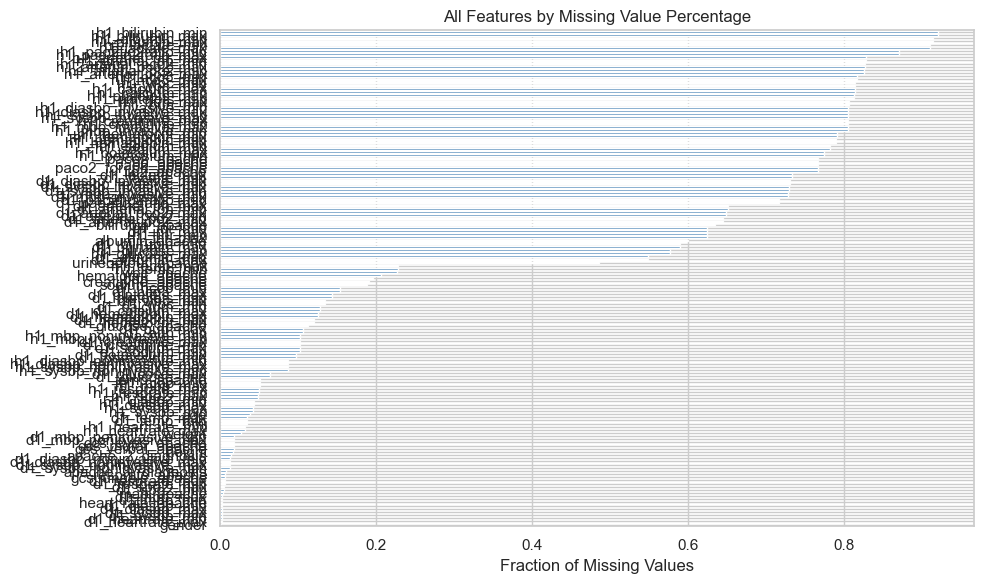

In [13]:
plt.figure(figsize=(10, 6))
missing_percent[missing_percent > 0].plot(kind='barh', color='steelblue')
plt.title("All Features by Missing Value Percentage")
plt.xlabel("Fraction of Missing Values")
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig("figures/missing_value_bar.png", dpi=300)
plt.show()


In [14]:
imputer = IterativeImputer(estimator = LGBMRegressor(
                                            n_estimators=333,
                                            n_jobs=-1,
                                            random_state=69,
                                            force_col_wise=True),
                           max_iter=1,
                           random_state=69,
                           initial_strategy='mean',
                           n_nearest_features=1,
                           add_indicator=True,skip_complete=True)

numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

X_train_numerical = X_train[numerical_cols]
imputer.fit(X_train_numerical)

X_train_numerical_imputed = imputer.transform(X_train_numerical)
X_test_numerical_imputed = imputer.transform(X_test[numerical_cols])

extended_cols = list(numerical_cols) + [f"{col}_indicator" for col in numerical_cols if X_train[col].isnull().any()]

X_train_numerical_imputed = pd.DataFrame(X_train_numerical_imputed, columns=extended_cols, index=X_train.index)
X_test_numerical_imputed = pd.DataFrame(X_test_numerical_imputed, columns=extended_cols, index=X_test.index)

X_train_imputed = pd.concat([X_train_numerical_imputed, X_train.loc[:, categorical_cols]], axis=1)
X_test_imputed = pd.concat([X_test_numerical_imputed, X_test.loc[:, categorical_cols]], axis=1)

X_train=X_train_imputed
X_test=X_test_imputed

print("shape of X_train:", X_train.shape)
print("shape of X_test:", X_test.shape)

missing_values_train = X_train.isnull().sum().sum()
missing_values_test = X_test.isnull().sum().sum()

print("Total missing values in X_train:", missing_values_train)
print("Total missing values in X_test:", missing_values_test)

[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 91060, number of used features: 1
[LightGBM] [Info] Start training from score 0.458335
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 90923, number of used features: 1
[LightGBM] [Info] Start training from score 103.314354
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 90923, number of used features: 1
[LightGBM] [Info] Start training from score 70.431167
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 90905, number of used features: 1
[LightGBM] [Info] Start training from score 148.263638
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 90905, number of used features: 1
[LightGBM] [Info] Start training from score 96.648325
[LightGBM] [Info] Total Bins 128
[LightGBM] [Info] Number of data points in the train set: 90903, number o

c:\Users\User\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


shape of X_train: (91109, 336)
shape of X_test: (39048, 336)
Total missing values in X_train: 0
Total missing values in X_test: 0


In [15]:
# def objective(trial):

#     global X_train, X_test, y_train, y_test

#     estimator_name = trial.suggest_categorical('estimator', ['LightGBM', 'ExtraTrees'])

#     if estimator_name == 'LightGBM':
#         estimator = LGBMRegressor(
#             n_estimators=trial.suggest_int('n_estimators', 100, 500),
#             n_jobs=-1,
#             random_state=69,
#             force_col_wise=True
#         )
    
#     elif estimator_name == 'ExtraTrees':
#         estimator = ExtraTreesRegressor(
#             n_estimators=trial.suggest_int('n_estimators', 50, 300),
#             n_jobs=-1,
#             random_state=69
#         )
    
#     max_iter = trial.suggest_int('max_iter', 1, 20)
#     n_nearest_features = trial.suggest_int('n_nearest_features', 1, 40)

#     # Create Iterative Imputer with suggested hyperparameters
#     imputer = IterativeImputer(
#         estimator=estimator,
#         max_iter=max_iter,
#         random_state=69,
#         initial_strategy='mean',
#         n_nearest_features=n_nearest_features,
#         add_indicator=True,
#         skip_complete=True
#     )

#     numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
#     categorical_cols = X_train.select_dtypes(include=['object']).columns

#     X_train_numerical = X_train[numerical_cols]
#     imputer.fit(X_train_numerical)

#     X_train_numerical_imputed = imputer.transform(X_train_numerical)
#     X_test_numerical_imputed = imputer.transform(X_test[numerical_cols])

#     extended_cols = list(numerical_cols) + [f"{col}_indicator" for col in numerical_cols if X_train[col].isnull().any()]

#     X_train_numerical_imputed = pd.DataFrame(X_train_numerical_imputed, columns=extended_cols, index=X_train.index)
#     X_test_numerical_imputed = pd.DataFrame(X_test_numerical_imputed, columns=extended_cols, index=X_test.index)

#     X_train_imputed = pd.concat([X_train_numerical_imputed, X_train.loc[:, categorical_cols]], axis=1)
#     X_test_imputed = pd.concat([X_test_numerical_imputed, X_test.loc[:, categorical_cols]], axis=1)

#     X_train=X_train_imputed
#     X_test=X_test_imputed

#     # Train a model to evaluate the imputation performance (RandomForestClassifier used here)
#     model = LGBMClassifier(random_state=69, n_jobs=-1,force_col_wise=True)
    
#     # Cross-validate the model on the imputed dataset
#     scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')
    
#     return np.mean(scores)


# study = optuna.create_study(direction='maximize') 
# study.optimize(objective, n_trials=50)

# # Print the best hyperparameters found
# print("Best hyperparameters: ", study.best_params)

In [16]:
X_train['set'] = 'train'
X_test['set'] = 'test'
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_train['set'] = 'train'
y_test['set'] = 'test'

combined_X = pd.concat([X_train, X_test])
combined_y = pd.concat([y_train, y_test])

combined = pd.concat([combined_X, combined_y], axis=1)

In [17]:
indicator_columns = [col for col in combined.columns if 'indicator' in col]
combined_filtered = combined.drop(columns=indicator_columns)

gender_mapping = {'M': 0, 'F': 1}
reverse_gender_mapping = {v: k for k, v in gender_mapping.items()}
combined_filtered['gender'] = combined_filtered['gender'].map(reverse_gender_mapping)


# Now apply the feature_generation function to the filtered DataFrame
combined_filtered = feature_generation(combined_filtered)

gender_mapping = {'M': 0, 'F': 1}
combined_filtered['gender'] = combined_filtered['gender'].map(gender_mapping)

#combined_filtered = combined_filtered.replace([np.inf, -np.inf], np.nan)

100%|██████████| 32/32 [00:25<00:00,  1.26it/s]


In [21]:
import pandas as pd
import numpy as np

# Step 1: Extract excluded columns
excluded_columns = combined[indicator_columns]

# Step 2: Downcast float64 and int64 to lower memory types
def downcast_df(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

combined_filtered = downcast_df(combined_filtered)
excluded_columns = downcast_df(excluded_columns)

# Optional: Convert binary indicator columns to bool if applicable
for col in excluded_columns.columns:
    if excluded_columns[col].nunique() <= 2:
        excluded_columns[col] = excluded_columns[col].astype('bool')

# Step 3: Perform concatenation safely
combined_final = pd.concat([combined_filtered, excluded_columns], axis=1)


C:\Users\User\AppData\Local\Temp\ipykernel_15852\997755387.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], downcast='float')
C:\Users\User\AppData\Local\Temp\ipykernel_15852\997755387.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], downcast='float')
C:\Users\User\AppData\Local\Temp\ipykernel_15852\997755387.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [22]:
# missing_values = combined_final.isnull().sum()
# missing_values = missing_values[missing_values > 0]

# print(missing_values)

In [23]:
duplicates = combined_final.columns[combined_final.columns.duplicated()]
print("Duplicate column names:", duplicates)

dup_indices = [i for i, col in enumerate(combined_final.columns) if col == 'set']

# Rename the duplicates specifically
if len(dup_indices) == 2:  # Ensure there are exactly two duplicates
    combined_final.columns.values[dup_indices[0]] = 'set_1'
    combined_final.columns.values[dup_indices[1]] = 'set_2'
else:
    print("Error: Unexpected number of duplicates for 'set'.")

# Verify the changes
print("Columns after renaming duplicates:")
print(combined_final.columns)

Duplicate column names: Index(['set'], dtype='object')
Columns after renaming duplicates:
Index(['encounter_id', 'hospital_id', 'age', 'bmi', 'elective_surgery', 'gender', 'height', 'icu_id', 'pre_icu_los_days', 'readmission_status',
       ...
       'd1_pao2fio2ratio_max_indicator', 'd1_pao2fio2ratio_min_indicator', 'h1_arterial_pco2_max_indicator', 'h1_arterial_pco2_min_indicator', 'h1_arterial_ph_max_indicator', 'h1_arterial_ph_min_indicator', 'h1_arterial_po2_max_indicator', 'h1_arterial_po2_min_indicator', 'h1_pao2fio2ratio_max_indicator', 'h1_pao2fio2ratio_min_indicator'], dtype='object', length=4302)


In [24]:
combined_final = combined_final.replace([np.inf, -np.inf], np.nan)

In [25]:
categorical_columns = combined_final.select_dtypes(include=['object']).columns

for col in categorical_columns:
    unique_values = combined_final[col].unique()
    print(f"Column '{col}' has {len(unique_values)} unique values:")
    print(unique_values)
    print("\n")

print("Shape of Data:", combined_final.shape)
print("Shape of Categorical:", categorical_columns.shape)

Column 'ethnicity' has 6 unique values:
['African American' 'Caucasian' 'Other/Unknown' 'Asian' 'Hispanic'
 'Native American']


Column 'hospital_admit_source' has 11 unique values:
['Emergency Department' 'Other' 'Direct Admit' 'Operating Room' 'Floor'
 'Recovery Room' 'Acute Care' 'SDU' 'PACU' 'ICU' 'Chest Pain Center']


Column 'icu_admit_source' has 4 unique values:
['Accident & Emergency' 'Operating Room / Recovery' 'Floor' 'Other']


Column 'icu_stay_type' has 3 unique values:
['admit' 'transfer' 'readmit']


Column 'icu_type' has 8 unique values:
['Med-Surg ICU' 'Neuro ICU' 'CCU-CTICU' 'CSICU' 'SICU' 'Cardiac ICU'
 'CTICU' 'MICU']


Column 'set_1' has 2 unique values:
['train' 'test']


Column 'set_2' has 2 unique values:
['train' 'test']


Column 'apache_3j_diagnosis_x' has 113 unique values:
['501' '702' '1506' '107' '407' '0' '1405' '403' '1903' '1204' '1502'
 '106' '1211' '1602' '601' '211' '111' '502' '306' '206' '104' '1207'
 '204' '410' '401' '1902' '305' '1408' '212' '12

In [26]:
columns_to_convert = ['apache_3j_diagnosis_x', 'apache_2_diagnosis_x', 'apache_3j_diagnosis_split1']
for column in columns_to_convert:
    combined_final[column] = pd.to_numeric(combined_final[column], errors='coerce')

combined_final[columns_to_convert] = combined_final[columns_to_convert].astype(int)

In [27]:
df_numeric = combined_final.select_dtypes(include=['int64', 'float64'])
combined_final[df_numeric.columns] = df_numeric.apply(pd.to_numeric, downcast='integer')
combined_final[df_numeric.columns] = df_numeric.apply(pd.to_numeric, downcast='float')

In [28]:
print(combined_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 130157 entries, 91852 to 83304
Columns: 4302 entries, encounter_id to h1_pao2fio2ratio_min_indicator
dtypes: bool(221), float32(3505), float64(5), int16(386), int32(5), int8(172), object(8)
memory usage: 1.9+ GB
None


In [29]:
object_columns = combined_final.select_dtypes(include=['object']).columns
object_columns = object_columns.difference(['set_1', 'set_2'])  
combined_final = pd.get_dummies(combined_final, columns=object_columns)

In [30]:
combined_final = combined_final.drop(columns=['encounter_id',"hospital_id"])

In [31]:
X = combined_final.drop(['diabetes_mellitus'], axis=1)
y = combined_final['diabetes_mellitus']

X_train = X[X['set_1'] == 'train'].drop(['set_1', 'set_2'], axis=1)
X_test = X[X['set_2'] == 'test'].drop(['set_1', 'set_2'], axis=1)

# Filter the targets
y_train = y[X['set_1'] == 'train']
y_test = y[X['set_2'] == 'test']

In [32]:
print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Labels Shape:", y_test.shape)

Training Features Shape: (91109, 4332)
Testing Features Shape: (39048, 4332)
Training Labels Shape: (91109,)
Testing Labels Shape: (39048,)


In [34]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Dummy loading - replace with your actual data loading if running locally
# X_train = pd.read_csv("X_train.csv")
# X_test = pd.read_csv("X_test.csv")

# Simulate example numeric column structure if not already loaded
numeric_columns = X_train.select_dtypes(include=['number']).columns

# Step 1: Mean Imputation
imputer = SimpleImputer(strategy='mean')
X_train[numeric_columns] = imputer.fit_transform(X_train[numeric_columns])
X_test[numeric_columns] = imputer.transform(X_test[numeric_columns])

# Step 2: Chunked Scaling
batch_size = 500  # Modify as needed based on system memory
scaled_train_chunks = []
scaled_test_chunks = []

for i in range(0, len(numeric_columns), batch_size):
    chunk_cols = numeric_columns[i:i+batch_size]
    scaler = StandardScaler()
    
    X_train_chunk = scaler.fit_transform(X_train[chunk_cols])
    X_test_chunk = scaler.transform(X_test[chunk_cols])
    
    scaled_train_chunks.append(pd.DataFrame(X_train_chunk, index=X_train.index, columns=chunk_cols))
    scaled_test_chunks.append(pd.DataFrame(X_test_chunk, index=X_test.index, columns=chunk_cols))

# Concatenate chunks back to full DataFrames
X_train_scaled = pd.concat(scaled_train_chunks, axis=1)
X_test_scaled = pd.concat(scaled_test_chunks, axis=1)

# Replace scaled numeric columns in original datasets
X_train[numeric_columns] = X_train_scaled
X_test[numeric_columns] = X_test_scaled

import ace_tools as tools; tools.display_dataframe_to_user(name="Scaled X_train Sample", dataframe=X_train.head())


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
# # If your X_train, X_test are DataFrames, and y_train, y_test are Series
# X_train.to_csv('X_train.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)

# y_train.to_csv('y_train.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

In [ ]:
def find_dataframes():
    # This will check for variables that are instances of pd.DataFrame in the global scope
    return {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

def print_memory_usage_of_dataframes():
    dataframes = find_dataframes()
    total_memory = 0
    print("Memory usage of dataframes (in GB):")
    for name, df in dataframes.items():
        mem_usage = df.memory_usage(deep=True).sum() / 1024 ** 3  # Convert bytes to gigabytes
        total_memory += mem_usage
        print(f"{name}: {mem_usage:.6f} GB")
    print(f"Total memory used by dataframes: {total_memory:.6f} GB")

print_memory_usage_of_dataframes()

Memory usage of dataframes (in GB):
data: 0.210982 GB
X: 2.033483 GB
X_train: 2.878939 GB
X_test: 1.233872 GB
X_train_numerical: 0.118793 GB
X_train_numerical_imputed: 0.225367 GB
X_test_numerical_imputed: 0.096589 GB
X_train_imputed: 0.259523 GB
X_test_imputed: 0.111187 GB
combined_X: 0.370711 GB
combined_y: 0.009419 GB
combined: 0.379160 GB
combined_filtered: 3.930096 GB
excluded_columns: 0.153220 GB
combined_final: 2.033968 GB
df_numeric: 3.974016 GB
Total memory used by dataframes: 18.019324 GB


In [ ]:
del df_numeric,combined_final,combined_filtered,X,data,excluded_columns,combined,combined_y,combined_X,X_test_imputed,X_train_imputed,X_test_numerical_imputed,X_train_numerical_imputed,X_train_numerical

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import numpy as np
original_feature_names = X_train.columns

In [ ]:
from lightgbm import LGBMClassifier

rf = LGBMClassifier(random_state=69, n_jobs=-1)

rf.fit(X_train, y_train)

n = 500
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:n]  


# Step 3: Map the top 10 features to their names
top_10_feature_names = original_feature_names[indices[:10]]

# Print top 10 feature names
print("Top 10 features selected by LightGBM:")
for i, feature in enumerate(top_10_feature_names, start=1):
    print(f"{i}. {feature}")


X_train_top_n = X_train.iloc[:, indices]
X_test_top_n = X_test.iloc[:, indices]

print(f"Top {n} features selected by Random Forest.")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.212537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 928847
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 4263
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
Top 10 features selected by LightGBM:
1. glucose_d1_value_range
2. age
3. glucose_d1_min_icu_id_mean
4. arf_apache
5. age_counts
6. glucose_d1_max_icu_id_norm_rank
7. d1_glucose_max
8. d1_hemaglobin_max_bmi_ratio
9. glucose_apache_d1_max_ratio
10. diabete_risk
Top 500 features selected by Random Forest.


In [ ]:
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1] 

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     30574
         1.0       0.69      0.50      0.58      8474

    accuracy                           0.84     39048
   macro avg       0.78      0.72      0.74     39048
weighted avg       0.83      0.84      0.83     39048

Accuracy: 0.8434746978078262
AUC-ROC Score: 0.8718983176719823


In [ ]:
rf = LGBMClassifier(random_state=69, n_jobs=-1)

rf.fit(X_train_top_n, y_train)

[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120167
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296


LGBMClassifier(n_jobs=-1, random_state=69)

In [ ]:
y_pred = rf.predict(X_test_top_n)
y_pred_proba = rf.predict_proba(X_test_top_n)[:, 1] 

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC Score:", auc_score)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     30574
         1.0       0.69      0.50      0.58      8474

    accuracy                           0.84     39048
   macro avg       0.78      0.72      0.74     39048
weighted avg       0.83      0.84      0.83     39048

Accuracy: 0.8428088506453596
AUC-ROC Score: 0.8719555384793314


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.065697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 928847
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 4263
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23657
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> 

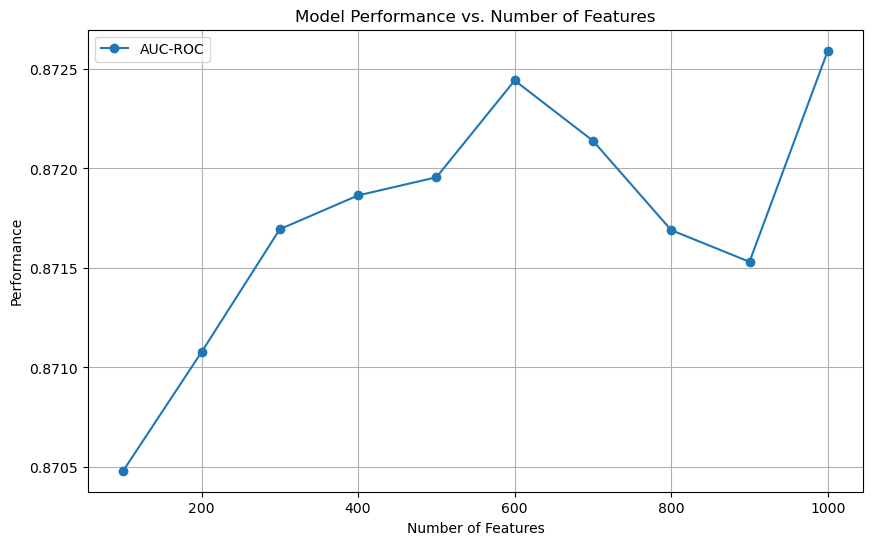

In [ ]:
auc_scores = []
n_features_list = list(range(100, 1100, 100))  
rf = LGBMClassifier(random_state=69, n_jobs=-1)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 

for n in n_features_list:
    # Select the top `n` features
    top_n_indices = indices[:n]
    
    # Create datasets with the top `n` features
    X_train_top_n = X_train.iloc[:, top_n_indices]
    X_test_top_n = X_test.iloc[:, top_n_indices]
    
    # Retrain the model using only the top `n` features
    rf.fit(X_train_top_n, y_train)
    
    # Make predictions on the test set
    y_pred = rf.predict(X_test_top_n)
    y_pred_proba = rf.predict_proba(X_test_top_n)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    auc_scores.append(auc_score)
    
    print(f"Features: {n}, AUC: {auc_score}")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_features_list, auc_scores, label='AUC-ROC', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Performance')
plt.title('Model Performance vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91109 entries, 91852 to 121958
Columns: 4332 entries, age to icu_type_SICU
dtypes: bool(105), float64(4227)
memory usage: 2.9 GB


In [ ]:
X_train.to_csv('X_train_large.csv', index=False)
X_test.to_csv('X_test_large.csv', index=False)
y_train.to_csv('y_train_large.csv', index=False)
y_test.to_csv('y_test_large.csv', index=False)

: 